# Классификация текстов с использованием Наивного Байесовского Классификатора

## Задание 1 (1 балл)

Откройте данные. Узнайте, сколько в них спам- и не спам-писем. Визуализируйте полученные соотношение подходящим образом.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
plt.style.use('seaborn-v0_8')

In [2]:

from sklearn import metrics

from sklearn import model_selection 
from sklearn.feature_extraction.text import CountVectorizer #модуль векторизации текста
from sklearn.naive_bayes import MultinomialNB #наивный байес

In [3]:
# откройте данные: ваш код здесь
df = pd.read_csv('data/spam_or_not_spam.csv')
df.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [4]:
# рассчитайте частоты для классов : ваш код здесь
df['label'].value_counts()

label
0    2500
1     500
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='percent'>

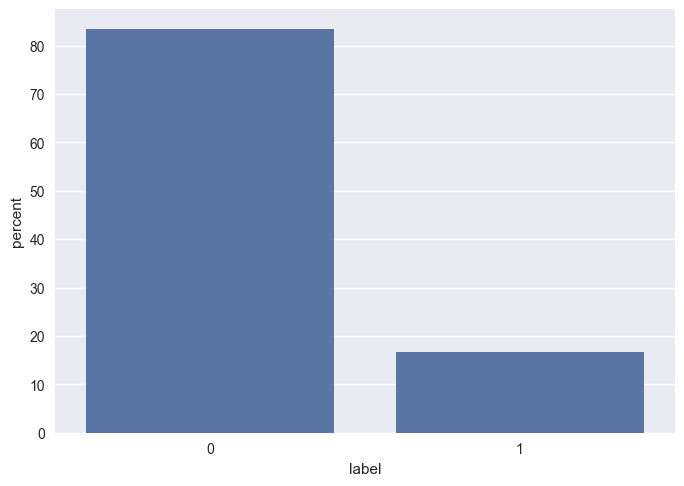

In [5]:
# визуализируйте результат: ваш код здесь
sns.countplot(df, x =df['label'], stat='percent')

## Задание 2 (2 балла)

Вам необходимо предобработать ваши данные и перевести их в векторный вид. Подгрузим необходимый модуль:

Замените в данных все пустые строки и строки, состоящие из пробелов, на пропуски (NaN). После этого удалите из данных все строки, в которых наблюдаются пропущенные значения.

In [6]:
#удаление любого символа (или группы символов), не являющегося буквой или цифрой(включая пробелы)
df['email'] = df['email'].str.replace("\W+", " ", regex=True)
#удаление пробелов перед и после строки, перевод в нижний регистр
df['email'] = df['email'].str.strip().str.lower()

In [7]:
#замена пустых(или содержащих пробелы) значений на пропуски
df['email'] = df['email'].replace(r'^\s*$', np.nan, regex=True)

In [8]:
df = df.dropna()

Переводим данные в векторный вид:

In [9]:
data = df.copy()
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data["email"])

Определите, сколько теперь признаков в нашем наборе данных:

In [10]:
#ваш код здесь
X.shape[1]

34116

## Задание 3 (2 балла)

Определите целевую переменную и признаки:

In [11]:
# целевая переменная
y = data['label']

Разделите выборку на обучающую и тестовую, используя стратифицированное разбиение (параметр `stratify` установите в значение вектора ответов y) размер тестовой выборки (`test_size`) возьмите как 0.25, параметр `random_state` определите со значением 42:

In [12]:
# ваш код здесь
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, stratify=y, random_state=42, test_size=0.25)

Рассчитайте среднее значение целевой переменной по тестовой выборке:

In [13]:
#ваш код здесь
y_test.mean()

0.16533333333333333

## Задание 4 (3 балла)

Определите и обучите подходящий алгоритм с параметром alpha = 0.01

In [14]:
alpha = 0.01
#наивный байес
nbm = MultinomialNB(alpha=alpha)
nbm.fit(X_train,y_train)
y_train_pred = nbm.predict(X_train)
y_test_pred = nbm.predict(X_test)

Оцените результат с точки зрения всех известных вам метрик (не менее трёх):

In [15]:
print('Метрики для обучающей выборки')
print(metrics.classification_report(y_train, y_train_pred, digits=4))
print('Метрики для тестовой выборки')
print(metrics.classification_report(y_test, y_test_pred, digits=4))

Метрики для обучающей выборки
              precision    recall  f1-score   support

           0     0.9989    1.0000    0.9995      1874
           1     1.0000    0.9946    0.9973       373

    accuracy                         0.9991      2247
   macro avg     0.9995    0.9973    0.9984      2247
weighted avg     0.9991    0.9991    0.9991      2247

Метрики для тестовой выборки
              precision    recall  f1-score   support

           0     0.9843    1.0000    0.9921       626
           1     1.0000    0.9194    0.9580       124

    accuracy                         0.9867       750
   macro avg     0.9921    0.9597    0.9750       750
weighted avg     0.9869    0.9867    0.9864       750



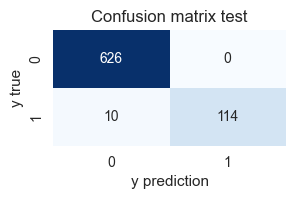

In [16]:
# Матрицу ошибок обернем в функцию
def confusion_matrix(y, y_pred, name_data):
	confusion_matrix1 = metrics.confusion_matrix(y, y_pred)

	# Визуализируем матрицы ошибок
	fig, axes = plt.subplots(figsize=(3, 1.5))  # фигура
	# Строим тепловую карту для первой матрицы ошибок
	sns.heatmap(confusion_matrix1,
				annot=True,
				cbar=False,
				fmt='',
				cmap='Blues')
	# Добавляем название графику и подписи осей абсцисс и ординат
	axes.set_title(f'Confusion matrix {name_data}')
	axes.set_xlabel('y prediction')
	axes.set_ylabel('y true');

confusion_matrix(y_test, y_test_pred, 'test')	

Метрика precision = 1 - значит модель не отнесла важные сообщения к спаму, при этом recall достаточно высок.

Нарисуйте ROC-кривую:

In [17]:
#вероятности предсказания классов
pred_proba_m = nbm.predict_proba(X_test)
#Выделяем столбец с вероятностями для класса 1 
pred_proba = pred_proba_m[:, 1]


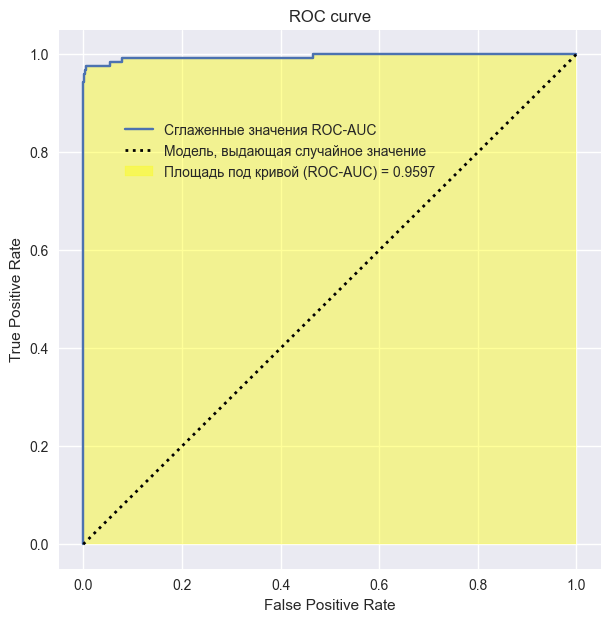

In [18]:
# получим координаты точек ROC кривой, а также значения порога threshold
false_positive_rates, true_positive_rates, threshold = metrics.roc_curve(
    y_test, pred_proba)
# площадь под кривой 
roc= metrics.roc_auc_score(y_test, y_test_pred).round(4)

# создаём график
plt.figure(figsize=(7, 7))

# рисуем кривую
plt.plot(false_positive_rates, true_positive_rates,
         label='Сглаженные значения ROC-AUC')

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':',
         label='Модель, выдающая случайное значение')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# закрашиваем площадь под кривой
plt.fill_between(false_positive_rates, true_positive_rates, step="pre",
                 color='yellow',
                 alpha=0.4, label=f'Площадь под кривой (ROC-AUC) = {roc}')
plt.legend(  # loc=1,
    		bbox_to_anchor=(0.1, 0.7)) #положение легенды
plt.show()

## Задание 5 (3 балла)

Переберите несколько значений alpha с помощью кросс-валидации. Оцените, зависит ли от этого параметра качество классификации.

In [19]:
#Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)

In [21]:
#Подберем alpha по сетке, причем alpha < 1
param_grid = [{'alpha':np.linspace(0.001, 1, 1000)}]

grid_search_1 = model_selection.GridSearchCV(
    estimator=MultinomialNB(), 
    param_grid=param_grid, 	
    cv=skf, 
    n_jobs = -1,
	scoring=['precision','roc_auc_ovo' ], #вычисление сразу двух метрик
	refit='roc_auc_ovo') #выбор основной метрики для работы .predict
						 #максимальное значение выберет лучшие из param_grid
	#refit='precision')
%time grid_search_1.fit(X_train, y_train) 
y_train_pred = grid_search_1.predict(X_train)
y_test_pred = grid_search_1.predict(X_test)
print('roc_auc_score на обучающем наборе: {:.4f}'.format(metrics.roc_auc_score(y_train, y_train_pred)))


CPU times: total: 9.7 s
Wall time: 29.1 s
roc_auc_score на обучающем наборе: 0.9946


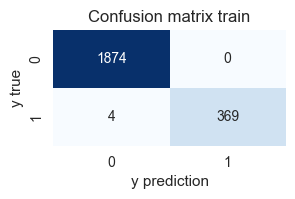

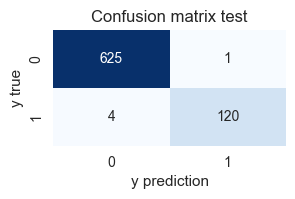

In [22]:
confusion_matrix(y_train, y_train_pred, 'train')
confusion_matrix(y_test, y_test_pred, 'test')

Rоличество ошибок уменьшилось, однако появилась ошибка 1-ого рода. 	

Попробуем подобрать оптимальную alpha , чтобы убрать ошибки 1-ого рода за счет увеличения ошибок 2-ого рода.
Идея: выбрть максимальное значение метрики 'Площадь под кривой (ROC-AUC)' среди нескольких значений precision, которые выше определенного уровня

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

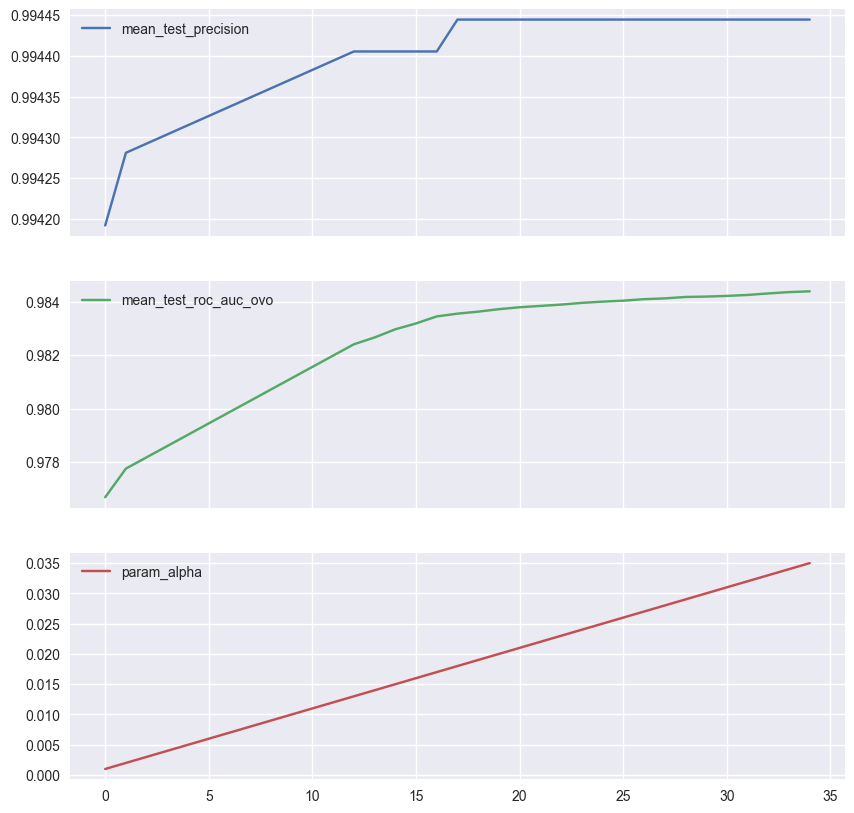

In [23]:
# Формируем dataFrame из двух метрик и alpha
best_param = pd.DataFrame(grid_search_1.cv_results_)[['mean_test_precision', 'mean_test_roc_auc_ovo', 'param_alpha',]]
# выбираем порог precision и берем первые 100 значений(по факту их получилось меньше)
best_param = best_param[best_param['mean_test_precision'] >0.992].sort_values(by='mean_test_roc_auc_ovo', ascending=False).head(100)
# рисуем графики изменения метрик в зависимости от alpha
best_param.sort_index().plot(subplots=True,figsize=(10, 10))

In [24]:
# выбираем alpha  соответсвующую максимальной  'roc_auc_ovo'
alpha = best_param['param_alpha'].iloc[0] # соответсвует первое значение т. к. df отсортирован по 'roc_auc_ovo'
print(f'Выбранная alpha {alpha}')
# Обучаем модель и предсказываем
nbm = MultinomialNB(alpha=alpha)
nbm.fit(X_train,y_train)
y_train_pred = nbm.predict(X_train)
y_test_pred = nbm.predict(X_test)

Выбранная alpha 0.035


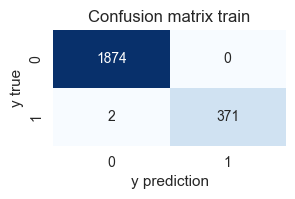

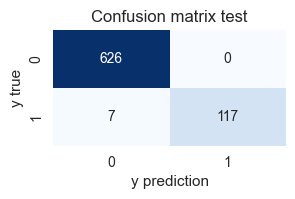

In [25]:
# Вывод матриц ошибок
confusion_matrix(y_train, y_train_pred, 'train')
confusion_matrix(y_test, y_test_pred, 'test')

Идея сработала. Результат удовлетворительный: FP = 0, FN - приемлемый 